#### Этап 1. Исследовательский анализ (EDA)

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image

Загрузка датасета ингридиентов

In [2]:
ingredients_df = pd.read_csv('data/ingredients.csv')
ingredients_df.head(3)

,id,ingr
0,1,cottage cheese
1,2,strawberries
2,3,garden salad


In [3]:
print('Количество ингридиентов:', ingredients_df.shape[0])

Количество ингридиентов: 555


In [4]:
ingredients_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 555 entries, 0 to 554
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      555 non-null    int64 
 1   ingr    555 non-null    object
dtypes: int64(1), object(1)
memory usage: 8.8+ KB


In [5]:
ingredients_df.value_counts('ingr')

ingr
deprecated    4
lemon         1
pecans        1
pepper        1
pepperoni     1
             ..
fish          1
fish oil      1
flatbread     1
flounder      1
fajitas       1
Name: count, Length: 552, dtype: int64

Стоит удалить deprecated ингредиенты и блюда, в которых они используются?

In [6]:
dep_ingr_ids = ingredients_df.loc[ingredients_df['ingr'] == 'deprecated', 'id'].to_list()

In [7]:
ingredients_df = ingredients_df[~ingredients_df['id'].isin(dep_ingr_ids)].reset_index(drop=True)

In [8]:
print('Количество ингридиентов:', ingredients_df.shape[0])

Количество ингридиентов: 551


In [9]:
ingredients_df.to_csv('data/ingredients_fixed.csv')

Загрузка датасета блюд

In [10]:
dishes_df = pd.read_csv('data/dish.csv')
dishes_df.head(3)

,dish_id,total_calories,total_mass,ingredients,split
0,dish_1561662216,300.794281,193.0,ingr_0000000508;ingr_0000000122;ingr_000000002...,test
1,dish_1561662054,419.438782,292.0,ingr_0000000312;ingr_0000000026;ingr_000000002...,train
2,dish_1562008979,382.936646,290.0,ingr_0000000448;ingr_0000000520;ingr_000000046...,test


In [11]:
print('Количество блюд:', dishes_df.shape[0])

Количество блюд: 3262


In [12]:
dep_dish_ids = []
for i, row in dishes_df.iterrows():
    ingredients = [int(item.split('_')[1]) for item in row['ingredients'].split(';')]
    for ingr in dep_ingr_ids:
        if ingr in ingredients:
            dep_dish_ids.append(row['dish_id'])
            break

In [13]:
dishes_df = dishes_df[~dishes_df['dish_id'].isin(dep_dish_ids)].reset_index(drop=True)

In [14]:
print('Количество блюд:', dishes_df.shape[0])

Количество блюд: 3231


In [15]:
dishes_df.to_csv('data/dish_fixed.csv')

In [16]:
dishes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3231 entries, 0 to 3230
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3231 non-null   object 
 1   total_calories  3231 non-null   float64
 2   total_mass      3231 non-null   float64
 3   ingredients     3231 non-null   object 
 4   split           3231 non-null   object 
dtypes: float64(2), object(3)
memory usage: 126.3+ KB


In [17]:
some_dishes_df = dishes_df.sample(n=5)

Калорийность блюда: 260.679993
Масса блюда: 475.0
Список игредиентов:
['berries', 'pineapple', 'honeydew melons', 'grapes']
(640, 480)


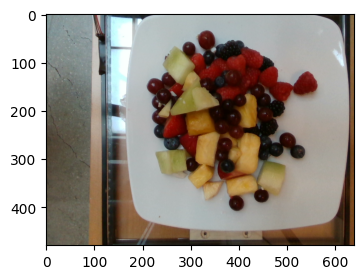

---
Калорийность блюда: 1324.084961
Масса блюда: 625.0
Список игредиентов:
['olives', 'broccoli', 'chicken', 'mixed greens', 'olive oil', 'vinaigrette']
(640, 480)


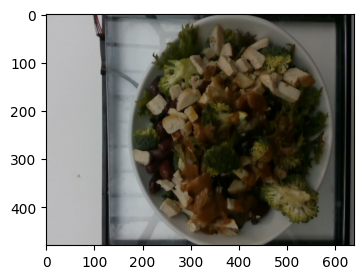

---
Калорийность блюда: 154.262009
Масса блюда: 286.0
Список игредиентов:
['broccoli', 'pears', 'mandarin oranges']
(640, 480)


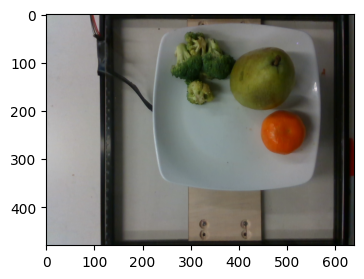

---
Калорийность блюда: 149.125931
Масса блюда: 149.0
Список игредиентов:
['tofu', 'walnuts', 'mustard', 'olive oil', 'vinegar', 'blueberries', 'salt', 'pepper', 'arugula', 'chard']
(640, 480)


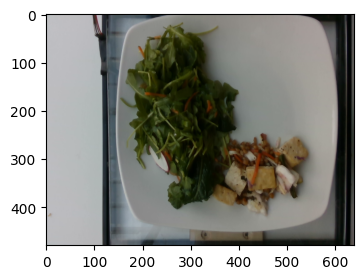

---
Калорийность блюда: 203.657364
Масса блюда: 217.0
Список игредиентов:
['caesar salad', 'cauliflower', 'cheese pizza', 'walnuts', 'mustard', 'olive oil', 'vinegar', 'blueberries', 'salt', 'pepper', 'arugula', 'chard']
(640, 480)


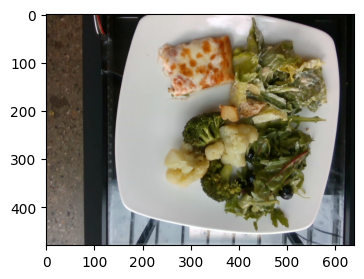

---


In [18]:
for i, row in some_dishes_df.iterrows():
    dish_id = row['dish_id']
    calories = row['total_calories']
    print('Калорийность блюда:', calories)
    mass = row['total_mass']
    print('Масса блюда:', mass)
    ingredients = row['ingredients'].split(';')
    ingredients_ids = [int(item.split('_')[1]) for item in ingredients]
    print('Список игредиентов:')
    print(ingredients_df.loc[ingredients_df['id'].isin(ingredients_ids)]['ingr'].to_list())
    
    img = Image.open(os.path.join('data/images', dish_id, 'rgb.png'))
    print(img.size)
    
    plt.figure(figsize=(20, 3))
    plt.imshow(np.array(img))
    plt.show()
    print('-' * 3)

1. Как вы будете решать задачу
- буду использовать мультимодальную модель, которая будет работать с изображениями и табличными данными.

2. Какие подходы к обогащению/аугментации данных примените и почему
- масштабирование;
- геометрические преобразования;
- цветовые преобразования;
- добавление шума.
3. На какие метрики будете ориентироваться при обучении
- MAE;
- loss.

#### Этап 2. Подготовка к обучению

In [19]:
from clearml import Logger, Task
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchmetrics

from src.config import Config
from src.dataset import MultimodalDataset, get_transforms, collate_fn
from src.model import MultimodalModel, set_requires_grad
from src.train import train, validate

/home/user/dishes_calorie_content/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [20]:
Task.set_offline(offline_mode=False)

In [21]:
task = Task.init(project_name='dishes_calorie_conten', task_name='training-7', auto_connect_frameworks=False)
task.connect(Config, name='Config')

ClearML Task: created new task id=c71e2562907c4e6f8384523b8aaaea45
ClearML results page: https://app.clear.ml/projects/0f3ae3e43c234775a15eac184bed68b2/experiments/c71e2562907c4e6f8384523b8aaaea45/output/log


src.config.Config

In [22]:
task.add_tags(['HuberLoss', 'edit-model'])

In [23]:
Config.check_save_path()

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
print('Используемое устрйоство:', device)

Используемое устрйоство: cuda


#### Этап 3. Обучение модели

In [26]:
train_losses, val_losses, train_metrics, val_metrics = train(Config, device)

/home/user/dishes_calorie_content/.venv/lib/python3.11/site-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


Epoch: 0 | val loss: 252.66411590576172, train loss: 254.24432650479403 | val mae: 254.05117797851562, train mae: 254.80545043945312
Epoch: 1 | val loss: 250.74855422973633, train loss: 252.14883076060903 | val mae: 252.13291931152344, train mae: 253.2006072998047
Epoch: 2 | val loss: 248.5735855102539, train loss: 250.94498651677912 | val mae: 249.9573516845703, train mae: 251.5592803955078
Epoch: 3 | val loss: 246.61859130859375, train loss: 249.49339155717328 | val mae: 248.0026092529297, train mae: 249.80892944335938
Epoch: 4 | val loss: 244.70543670654297, train loss: 246.33861888538706 | val mae: 246.0888671875, train mae: 247.84751892089844
Epoch: 5 | val loss: 242.2086524963379, train loss: 246.70530561967328 | val mae: 243.58792114257812, train mae: 245.58663940429688
Epoch: 6 | val loss: 239.5807762145996, train loss: 242.5703020962802 | val mae: 240.95541381835938, train mae: 243.06539916992188
Epoch: 7 | val loss: 236.49553298950195, train loss: 239.49593075838956 | val mae

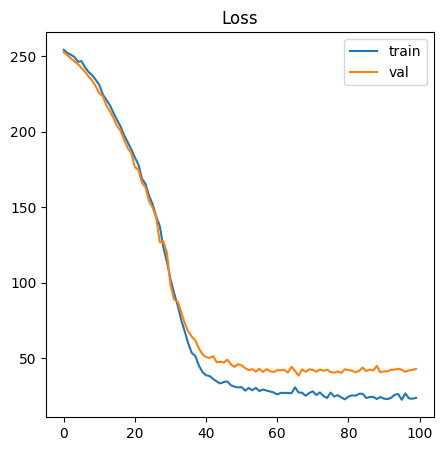

In [27]:
plt.figure(figsize=(5, 5))
plt.title('Loss')
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.show()

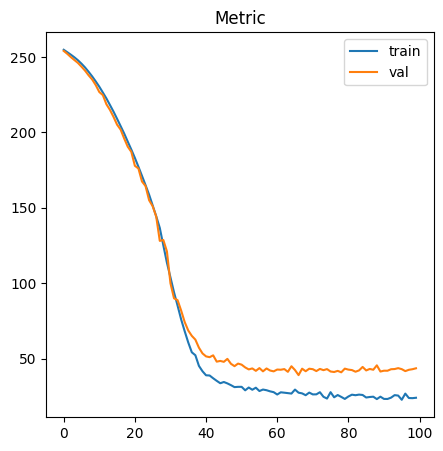

In [28]:
plt.figure(figsize=(5, 5))
plt.title('Metric')
plt.plot(train_metrics, label='train')
plt.plot(val_metrics, label='val')
plt.legend()
plt.show()

In [29]:
task.close()

#### Этап 4. Валидация качества

In [90]:
model = MultimodalModel(config=Config).to(device)
set_requires_grad(model.image_model, unfreeze_pattern=Config.IMAGE_MODEL_UNFREEZE)

In [91]:
state_dict = torch.load('models/epoch_66.pth')

In [92]:
model.load_state_dict(state_dict)
model.to(device)
model.eval()

MultimodalModel(
  (mlp): Sequential(
    (0): Linear(in_features=551, out_features=1024, bias=True)
    (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=1024, out_features=512, bias=True)
  )
  (image_model): EfficientNet(
    (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (aa): Ident

In [93]:
val_dataset = MultimodalDataset(config=Config,
                                transforms=get_transforms(config=Config, ds_type='test'),
                                ds_type='test')

val_loader = DataLoader(dataset=val_dataset, batch_size=Config.BATCH_SIZE,
                        shuffle=False, num_workers=Config.NUM_WORKERS,
                        collate_fn=collate_fn)

mae_metric_val = torchmetrics.MeanAbsoluteError().to(device)


dish_ids = []
dish_cals = []
for batch in val_loader:
    dish_ids.extend(batch['dish_ids'])

    inputs = {
            'image': batch['image'].to(device),
            'table_data': batch['table_data'].to(device),
            'total_mass': batch['total_mass'].to(device)
        }
    labels = batch['label'].to(device)

    outputs = model(**inputs)
    _ = mae_metric_val(preds=outputs, target=labels)

    dish_cals.extend(outputs.detach().cpu().squeeze(1).tolist())
    
val_mae = mae_metric_val.compute().cpu().numpy()
print('Значение MAE на валидационной выборке:', val_mae)
mae_metric_val.reset()

Значение MAE на валидационной выборке: 39.116623


In [94]:
bad_5 = sorted(zip(dish_ids, dish_cals), key=lambda x: x[1], reverse=True)[:5]

In [95]:
dishes_df = pd.read_csv(Config.DISHES_PATH)
ingredients_df = pd.read_csv(Config.INGREDIENTS_PATH)

Ингрtдиенты блюда: ['almonds', 'sausage', 'grapes']


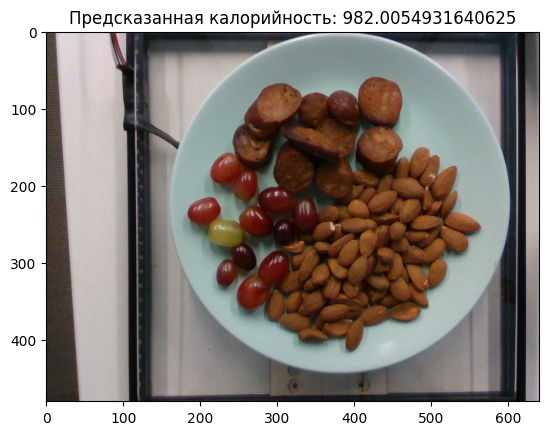

----------------------------------------------------------------------------------------------------
Ингрtдиенты блюда: ['chicken', 'pepper', 'cookies', 'brown rice', 'arugula', 'vinegar', 'oregano', 'tatsoi', 'olive oil', 'basil', 'cilantro', 'white wine', 'salt', 'roasted potatoes', 'garlic', 'shallots', 'cauliflower', 'mushroom', 'steak', 'jalapenos', 'cream', 'wheat berry', 'thyme', 'butter', 'rosemary', 'lemon juice', 'parsley']


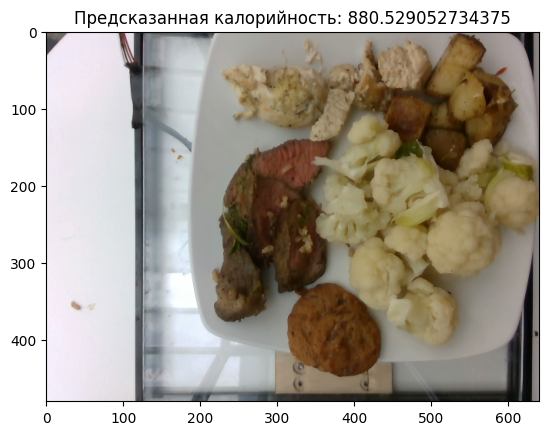

----------------------------------------------------------------------------------------------------
Ингрtдиенты блюда: ['shallots', 'olive oil', 'garlic', 'lemon juice', 'basil', 'cream', 'wheat berry', 'mushroom', 'arugula', 'cherry tomatoes', 'quinoa', 'chicken', 'pepper', 'bell peppers', 'white wine', 'lettuce', 'feta cheese', 'roasted potatoes', 'onions', 'butter', 'thyme', 'rosemary', 'cucumbers', 'olives', 'oregano', 'vinaigrette', 'salt']


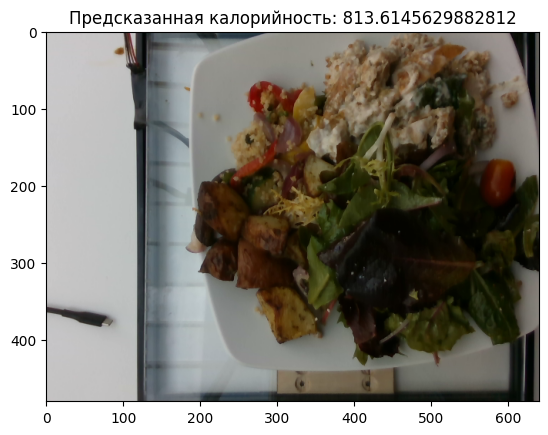

----------------------------------------------------------------------------------------------------
Ингрtдиенты блюда: ['cream', 'mushroom', 'spinach (raw)', 'olive oil', 'pasta', 'beef', 'wine', 'garlic', 'sour cream', 'onions', 'thyme', 'salt']


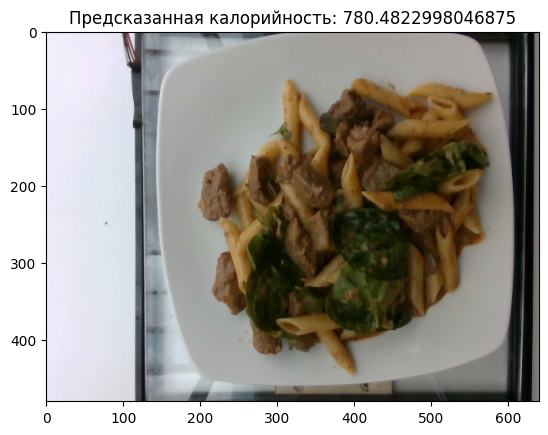

----------------------------------------------------------------------------------------------------
Ингрtдиенты блюда: ['garlic', 'pepper', 'mushroom', 'oregano', 'cream', 'wheat berry', 'butter', 'basil', 'salt', 'shallots', 'white wine', 'chicken', 'quinoa', 'arugula', 'thyme', 'olive oil', 'rosemary', 'lemon juice', 'roasted potatoes']


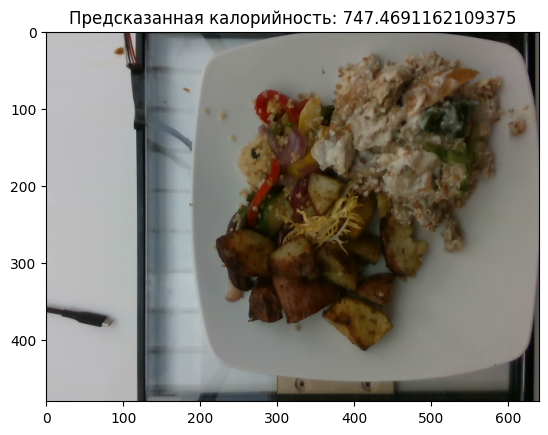

----------------------------------------------------------------------------------------------------


In [96]:
for dish in bad_5:
    dish_id = dish[0]
    img = Image.open(os.path.join(Config.IMAGE_PATH, dish_id, 'rgb.png'))

    ingredients = dishes_df[dishes_df['dish_id'] == dish_id].iloc[0]['ingredients']
    ingrs = []
    for item in ingredients.split(';'):
        idx = int(item.split('_')[1])
        ingrs.append(ingredients_df[ingredients_df['id'] == idx].iloc[0]['ingr'])
    print('Ингрtдиенты блюда:', ingrs)

    plt.title(f'Предсказанная калорийность: {dish[1]}')
    plt.imshow(img)
    plt.show()
    print('-' * 100)

Причины низкого качества представленных выше блюд:
- малая яркость изображения;
- наложение ингредиентов дряг на друга;
- сложный рецепт приготовления блюда.